# Eulerian Video Magnification 算法介绍

为了更好地帮助大家理解Eulerian Video Magnification算法，我将结合代码和原始论文，对算法的实现原理进行详细的介绍。

## 一、Spactial Processing：图像金字塔

为了理解EVM算法是如何使用空间分解的（Spatial Decomposition）, 我们首先需要了解什么是图像金字塔（Image Pyramid）。

<div>
<img src="图像金字塔.png" width="500"/>
</div>

> **定义1.1** 图像金字塔或金字塔表示是计算机视觉领域的多尺度信号表示，其中信号或图像受到重复平滑和子采样的影响。这种技术的一个常见应用是图像压缩。这里我们重点关注高斯金字塔和拉普拉斯金字塔。

## 1.2 高斯金字塔和拉普拉斯金字塔

Laplacian Pyramid提出时是一种图像压缩技术。它是由Burt和Adelson在1983年提出的。它的示意图如下：
![alt text](Laplacian金字塔示意图2.png)

### 1.2.1 高斯金字塔
从上图可以看出，高斯金字塔是由原始图像不断平滑+下采样得到的。抽象的记法如下：
$$G_{i+1} = Down(G_i)$$
如果我们选取一个5x5的高斯核
$$
W = \frac{1}{256}
\begin{bmatrix}
1 & 4 & 6 & 4 & 1 \\
4 & 16 & 24 & 16 & 4 \\
6 & 24 & 36 & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 & 4 & 6 & 4 & 1 \\
\end{bmatrix}
$$
那么，上述公式具体到像素的计算公式为：
$$
G_{l+1}(i, j) = \sum_{m=-2}^{2} \sum_{n=-2}^{2} W(m, n) G_l(2i+m, 2j+n)
$$
注意，上述公式说明高斯滤波在下采样之前进行，否则，公式中不会出现包含$G_{l}(2i+m, 2j+n)$，而只会出现包含$G_{l}(2i+2m, 2j+2n)$的项。
那么这里用高斯核对图像作二维卷积的作用是什么呢？我们通过下面的代码来展示，高斯核卷积具有抗混叠的作用，从而最小化图像降采样时的失真。

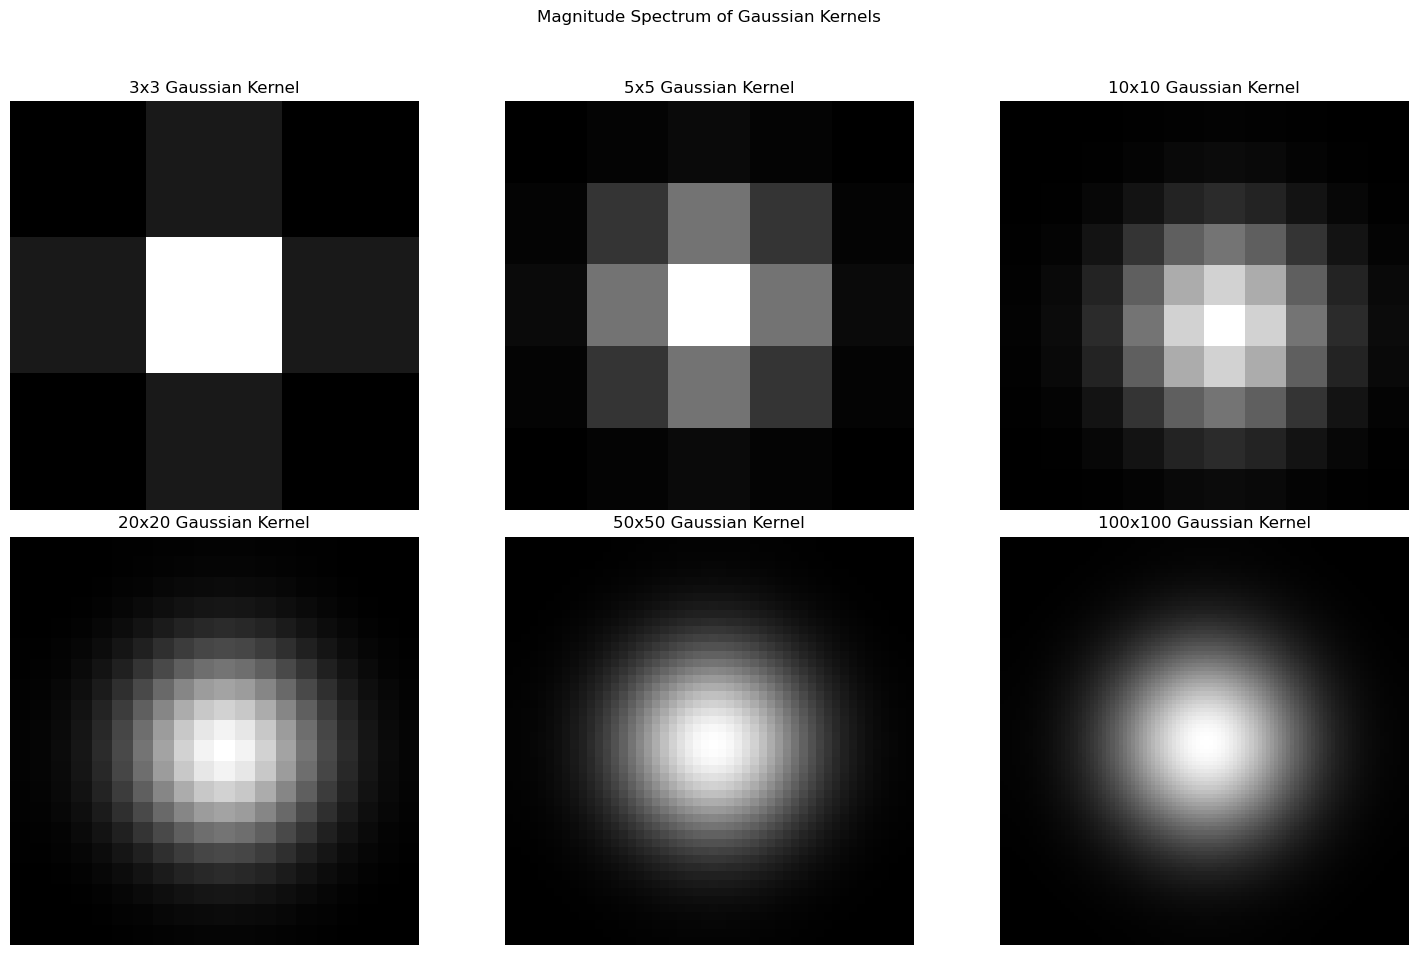

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def create_gaussian_kernel(size, sigma=1):
    """Create a square Gaussian kernel."""
    kernel = np.zeros((size, size))
    kernel[size // 2, size // 2] = 1
    return gaussian_filter(kernel, sigma=sigma)

# Define the sizes of Gaussian kernels
sizes = [3, 5, 10, 20, 50, 100]

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot magnitude spectra for different sizes of Gaussian kernels
for i, size in enumerate(sizes):
    kernel = create_gaussian_kernel(size)
    F = np.fft.fft2(kernel)
    magnitude_spectrum = np.abs(F)
    
    ax = axs[i // 3, i % 3]
    ax.imshow(np.fft.fftshift(magnitude_spectrum), cmap='gray')
    ax.set_title(f'{size}x{size} Gaussian Kernel')
    ax.axis('off')  # Turn off the axis

plt.suptitle('Magnitude Spectrum of Gaussian Kernels')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


上面是各个高斯卷积核的频谱图。我们知道，像素空间中的卷积等价于频域卷积，可以看到，在高斯核的频谱图在中心是一个圆形，这说明高斯核是一个低通滤波器。因此，从信息传递地角度来说，在我们在下采样的过程中尽量地保留了低频信息，而丢弃了高频信息。如果我们不进行高斯滤波，直接下采样。由于奈奎斯特准则，采样频率的不断下降将导致真实图像中的高频部分在金字塔中的某一层起大于两倍的采样频率，从而导致混叠现象（例如：课上提到的摩尔云纹）。这将使得图像的重建过程很难再还原。

### 1.2.2 拉普拉斯金字塔
在讲Laplacian金字塔之前，我们看看Gaussion金字塔的重建过程，即从高斯金字塔的底层开始，通过上采样+卷积得到高一层的图像。抽象的记法如下：
$$G_{l-1}^{R} = Up(G_l)$$
对应到像素的计算公式为：
$$
G_{l-1}^{R}(i, j) = 4 \sum_{m=-2}^{2} \sum_{n=-2}^{2} W(m, n) G_l(\frac{i-m}{2}, \frac{j-n}{2})
$$
上述公式中，$G_{l-1}^{R}$表示重建的图像，$G_{l}$表示高斯金字塔的第$l$层图像。注意，上述公式中的4是为了归一化。

虽然，通过高斯滤波等抗混叠技术，我们可以在下采样的过程中尽量保留低频信息，但是，我们还是会丢失一些高频信息。因此，在Gaussian金字塔的基础上，我们可以通过拉普拉斯金字塔来保留这些高频信息。

拉普拉斯金字塔的计算公式如下：
$$L_{l} = G_{l} - Up(G_{l+1}) = G_{l}-Up(Down(G_{l}))$$
因此，只要我们保存Laplacian金字塔的每一层，以及Gaussian金字塔的最后一层，我们就可以通过如下重建过程得到原始图像:
1. 从Gaussian金字塔的最后一层开始，通过上采样+卷积得到高一层的图像。
2. 将得到的高一层的图像与Laplacian金字塔的最后层相加，得到原始图像的倒数第二层。
3. 重复上述过程，直到得到原始图像。

一个可能的问题是，为什么，我们不直接保存原始图像，而是要保存一整个Laplacian金字塔呢？这是因为，Laplacian金字塔的每一层都做了图像的去相关性，具有更小的方差和熵。这里我们不做详细的推导，因为Laplacian金字塔的数据压缩功能并不是本文的重点，有兴趣可以去读Burt和Adelson的原始论文The Laplacian Pyramid as a Compact Image Code。

## 二、Temporal Processing：滤波器

上述的图像金字塔部分将视频的空间信息按照空间频带进行了分解，接下来我们将对视频的时间信息进行分解。

## 2.1 滤波器

在EVM算法中，我们需要对特定时间频率的动作进行放大，因此，我们希望对每点$(x,y)$的像素信号$I(t)|_{x,y}$进行时间滤波，得到滤波信号$I'(t)|_{x,y}$。在代码中，我们可以看到滤波是这样实现的：
$$
I'(t)|_{x,y} = a_{0}I(t)|_{x,y}+a_{1}I(t-1)|_{x,y}-b_{1}I'(t-1)|_{x,y}
$$
其中，$a_{0},a_{1},b_{1}$是滤波器的系数。那么，为什么这样的差分操作可以实现对特定频率的动作进行放大呢？下面，我将介绍它的数学原理。

### 2.1.1 Laplace变换与Z变换

我们知道，拉普拉斯变换是一种连续信号的频域分析方法，其表达式如下：
$$
F(s) = \int_{0}^{\infty} f(t)e^{-st}dt
$$
其中，$s=\sigma+j\omega$是复数变量。而Z变换是一种离散信号的频域分析方法，其表达式如下：
$$
X(z) = \sum_{n=0}^{\infty} x(n)z^{-n}
$$
准确地说，上式为单边Z变换，适用于$t>0$的情况。双边Z变换的表达式为：
$$
X(z) = \sum_{n=-\infty}^{\infty} x(n)z^{-n}
$$
下面，我们介绍将拉普拉斯变换转化为Z变换的方法——双线性变换(Bilinear Transform)。

如果我们将一个离散信号用狄拉克函数表示为连续信号的形式，那么我们可以得到：
$$
x(t) = \sum_{n=0}^{\infty} x(n)\delta(t-nT_{s})
$$
其中，$T_{s}$是采样周期。如果我们将上式进行拉普拉斯变换，我们可以得到：
$$
X(s) = \sum_{n=0}^{\infty} x(n)e^{-snT_{s}}
$$
于是我们有：
$$
z = e^{sT_{s}}
$$
而双线性变换则是对上式的一阶近似：
$$
\begin{aligned}
z &= e^{sT_{s}} \\
&= e^{\frac{1}{2}sT_{s}}/e^{-\frac{1}{2}sT_{s}} \\
&\approx \frac{1+\frac{1}{2}sT_{s}}{1-\frac{1}{2}sT_{s}}
\end{aligned}
$$
由此，我们可以写出将拉普拉斯变换的s域转化为Z域的z的变换关系：
$$
s = \frac{2}{T_{s}}\frac{(z-1)}{(z+1)}
$$


参考：
1. https://blog.csdn.net/qq_32515081/article/details/117202181
2. https://en.wikipedia.org/wiki/Bilinear_transform
3. https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Discretization/Bilinear-transform.html

### 2.1.2 传递函数,频率响应与频率弯折

一个系统的传递函数是系统的输入和输出之间的关系。对于一个线性时不变系统，我们可以通过拉普拉斯变换得到系统的传递函数：
$$
H_{a}(s) = \frac{Y(s)}{X(s)}
$$
其中，$Y(s)$是系统的输出，$X(s)$是系统的输入。对于一个离散系统，我们可以通过Z变换得到系统的传递函数：
$$
H_{d}(z) = \frac{Y(z)}{X(z)}
$$
对于一个系统的频率响应，我们可以通过分析$s=j\omega_{a}$或者$z=e^{j\omega_{d}}$的情况下的传递函数得到。即$H_{a}(j\omega_{a})$或者$H_{d}(e^{j\omega_{d}})$。

然而需要注意的是，离散系统与连续系统的频率变换不是线性的。事实上，由双线性变换我们可以得到：
$$
\begin{aligned}
e^{j\omega_{d}} = z &= \frac{1+\frac{1}{2}j\omega_{a}T_{s}}{1-\frac{1}{2}j\omega_{a}T_{s}}\\
&= \frac{(1+\frac{1}{2}j\omega_{a}T_{s})^{2}}{1+(\frac{\omega_{a}T_{s}}{2})^{2}}\\
&= \frac{1-\frac{1}{4}\omega_{a}^{2}T_{s}^{2}}{1+\frac{1}{4}\omega_{a}^{2}T_{s}^{2}}+j\frac{\omega_{a}T_{s}}{1+\frac{1}{4}\omega_{a}^{2}T_{s}^{2}}
\end{aligned}
$$
因此，
$$
\begin{aligned}
&\omega_{d} = arg(z) = \arctan(\frac{\omega_{a}T_{s}}{1-\frac{1}{4}\omega_{a}^{2}T_{s}^{2}})\\
&\iff tan(\omega_{d}) = \frac{\omega_{a}T_{s}}{1-\frac{1}{4}\omega_{a}^{2}T_{s}^{2}}\\
&\iff tan(\omega_{d})T_{s}^{2}\omega_{a}^{2}+4T_{s}\omega_{a}-4tan(\omega_{d}) = 0
\end{aligned}
$$
这是一个二次方程，我们可以通过求解这个方程得到$\omega_{a}$与$\omega_{d}$之间的关系：
$$
\begin{cases}
\omega_{a,1} = \frac{2}{T_{s}}tan\frac{\omega_{d}}{2}\\
\omega_{a,2} = \frac{2}{T_{s}}tan\frac{\omega_{d}+\pi}{2}
\end{cases}
$$

经检验，仅有$\omega_{a,1}$是有效的，因此，我们可以得到：
$$
\omega_{a} = \frac{2}{T_{s}}tan\frac{\omega_{d}}{2}
$$
因此，我们知道，离散系统的频率响应与连续系统的频率响应之间的关系是非线性的，这一现象被称为**频率弯折**(frequency warping)。

### 2.1.3 有限/无限脉冲响应滤波器

在信号处理中，**有限脉冲响应**(Finite Impulse Response, FIR)滤波器和**无限脉冲响应**(Infinite Impulse Response, IIR)滤波器是两种常见的滤波器。FIR滤波器的输出仅取决于输入信号的有限数量的值，而IIR滤波器的输出取决于输入信号的无限数量的值。这里，有限脉冲响应是指系统的单位脉冲响应在有限时间内衰减到零，而无限脉冲响应是指系统的单位脉冲响应在任意长的时间内都不会衰减到零。


FIR滤波器的构造十分自然。**我们知道，信号的时域卷积等价于频域的乘积。** 因此，我们只需要构造一个在傅里叶变换下频域上仅在特定频率区间上有值，其余为0的滤波器频谱$H(\omega)$，然后通过傅里叶逆变换即可得到时域上的滤波器$h(t)$，如下图所示。
![alt text](FIR滤波器实现逻辑.jpg)


我们只需要对信号输入$x(t)$进行卷积即可得到滤波后的信号$y(t)$。其输入与最近输入信号有关。一个$N$阶的FIR滤波器，其输出$y[n]$可以表示为：
$$
\begin{aligned}
y[n] &=b_{0}x[n]+b_{1}x[n-1]+\dots+b_{N}x[n-N]\\
&= \sum_{k=0}^{N} b_{k}x[n-k]
\end{aligned}
$$

下面展示一种简单的移动平均FIR滤波器的实现：
我们取$N=2$,即：
$$
h[n] = \frac{1}{3}\delta[n] + \frac{1}{3}\delta[n-1] + \frac{1}{3}\delta[n-2]
$$
其频率响应(或傅里叶变换)为：
$$
\begin{aligned}
H_{(d)}(e^{j\omega}) &= \frac{1}{3} + \frac{1}{3}e^{-j\omega} + \frac{1}{3}e^{-j2\omega}\\
&= \frac{1}{3}e^{-j\omega}(1+2\cos(\omega))
\end{aligned}
$$
其中，$H(z)$表示滤波器的频率响应的z变换。
下面这段代码展示了其幅频特性和相频特性，可以看出，这是一个粗略的低通滤波器。

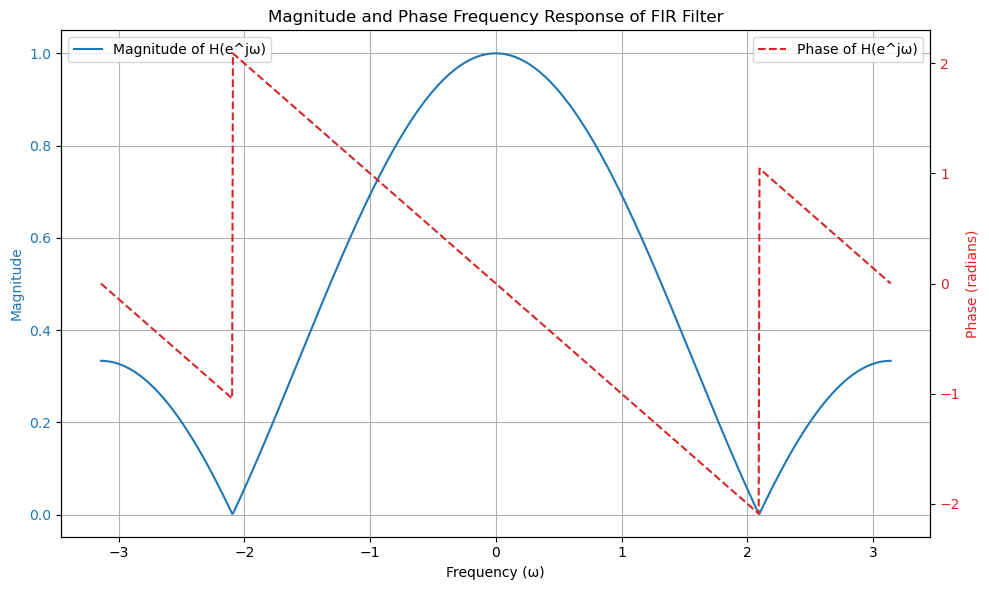

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 定义频率范围
omega = np.linspace(-np.pi, np.pi, 1000)

# 计算滤波器的频率响应
H = (1/3) * (1 + np.exp(-1j * omega) + np.exp(-2j * omega))

# 计算幅度
H_magnitude = np.abs(H)

# 计算相位
H_phase = np.angle(H)

# 创建图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制幅频特性
color = 'tab:blue'
ax1.set_xlabel('Frequency (ω)')
ax1.set_ylabel('Magnitude', color=color)
ax1.plot(omega, H_magnitude, color=color, label='Magnitude of H(e^jω)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.legend(loc='upper left')

# 创建第二个y轴用于相频特性
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Phase (radians)', color=color)
ax2.plot(omega, H_phase, color=color, linestyle='dashed', label='Phase of H(e^jω)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# 设置图的标题
plt.title('Magnitude and Phase Frequency Response of FIR Filter')

# 显示图形
fig.tight_layout() 
plt.show()


IIR滤波器的构造源自模拟滤波器的设计。我们首先来看下面的RC电路：
![alt text](RC谐振电路示意图.png)

我们知道电压满足的方程为：
$$
V_{in} = V_{out} + RC\frac{dV_{C}}{dt}
$$
对上式进行拉普拉斯变换，我们可以得到：
$$
V_{out}(s) = \frac{1}{1+RCs}V_{in}(s)
$$
于是，该系统的传递函数为：
$$
G(s) = \frac{1}{1+RCs}
$$
下面我们画出当$R=1,C=1$时，其幅频特性和相频特性。

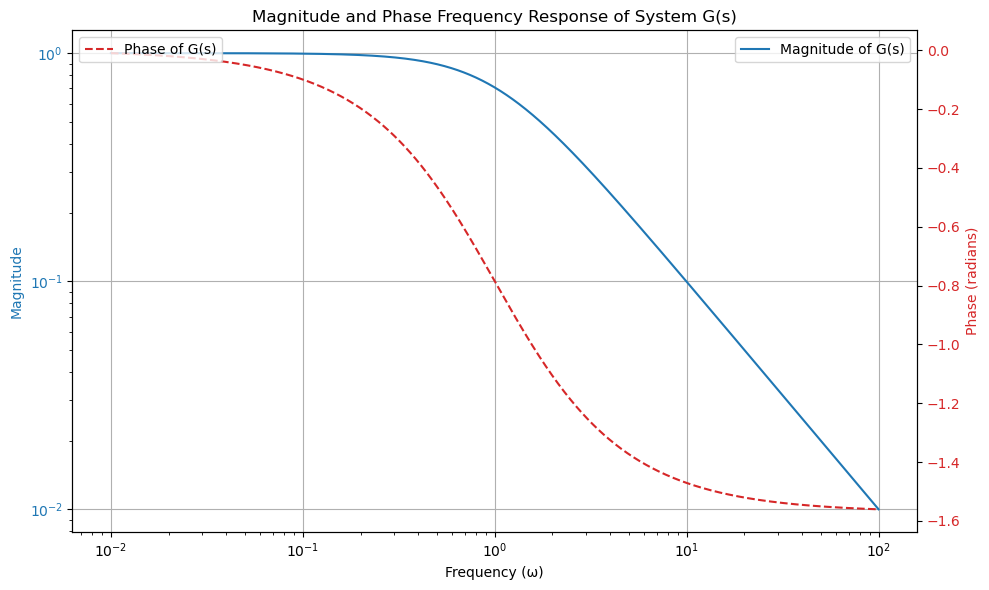

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 定义频率范围
omega = np.logspace(-2, 2, 1000)

# 定义系统参数
R = 1
C = 1

# 计算系统的传递函数
G = 1 / (1 + R * C * 1j * omega)

# 计算幅度响应和相位响应
G_magnitude = np.abs(G)
G_phase = np.angle(G)

# 创建图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制幅频特性
color = 'tab:blue'
ax1.set_xlabel('Frequency (ω)')
ax1.set_ylabel('Magnitude', color=color)
ax1.loglog(omega, G_magnitude, color=color, label='Magnitude of G(s)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.legend(loc='upper right')

# 创建第二个y轴用于相频特性
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Phase (radians)', color=color)
ax2.semilogx(omega, G_phase, color=color, linestyle='dashed', label='Phase of G(s)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')

# 设置图的标题
plt.title('Magnitude and Phase Frequency Response of System G(s)')

# 显示图形
fig.tight_layout() 
plt.show()


可以看出，这是一个低通滤波器,在后面我们将会看到，该系统就是一个一阶Butterworth滤波器。截止频率为$\omega_{c} = \frac{1}{RC}=1$。并且，相移因子随频率变化是非线性的。

下面，我们用双线性变换将上述模拟滤波器离散化，即代入$s = \frac{2}{T}\frac{1-z}{1+z}$，我们可以得到：
$$
\frac{Y(z)}{X(z)} = H(z) = \frac{T\omega_{c}(1+z^{-1})}{2(1-z^{-1})+T\omega_{c}(1+z^{-1})}
$$
整理得到：
$$
[(2+T\omega_{c})+(T\omega_{c}-2)z^{-1}]Y(z) = T\omega_{c}(1+z^{-1})X(z)
$$
注意到Z变换的时移性质$z^{-1}X(n)=X(n-1)$，我们可以得到：
$$
y[n] = \frac{T\omega_{c}}{2+T\omega_{c}}x[n] + \frac{T\omega_{c}}{2+T\omega_{c}}x[n-1] + \frac{2-T\omega_{c}}{2+T\omega_{c}}y[n-1]
$$

我们可以看到，该IIR滤波器的输出不仅与输入有关，还与上一时刻的输出有关，因此，IIR滤波器的输出是无限脉冲响应的。

参考：
1. https://www.zhihu.com/question/323353814/answer/2708545913
2. https://zhuanlan.zhihu.com/p/161948566?utm_medium=social&utm_psn=1777741961287950336&utm_source=wechat_session

### 2.1.4 Butterworth滤波器

下面我们来看看EVM算法中的滤波器是如何设计的。首先，我们来看看评价滤波器性能的指标，如下图所示：
![alt text](数字滤波器的幅频特性和技术指标.png)

在上图中，$[0,\omega_{p}]$称为通带，$[\omega_{st},\pi]$称为阻带,$[\omega_{p},\omega_{p_{st}}]$称为过渡带。

$\delta_{1}$为通带响应的容限，$\delta_{2}$为阻带响应的容限。

$R_{p}$为通带波纹，$A_{s}$为阻带衰减。

巴特沃斯滤波器是一种无限脉冲响应的滤波器，其特点是通带波纹$R_{p}$最小(即通带幅频特性最平滑)。下面我们来看看巴特沃斯滤波器的设计方法。
一个N阶归一化巴特沃斯滤波器的传递函数应当满足：
$$
|H_{N}(j\omega)|^{2} = \frac{1}{1+(\omega)^{2N}}
$$
首先，我们看一下它的幅频特性

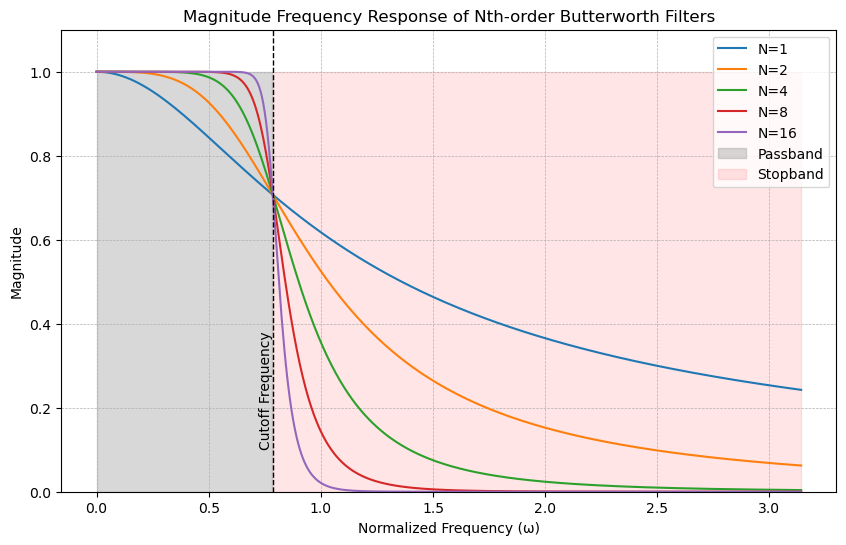

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 定义频率范围（标准化频率）
omega = np.linspace(0, np.pi, 500)  # 从0到π之间的线性刻度频率

# 定义截止频率（标准化）
omega_c = np.pi / 4  # 这里将截止频率设置为π/4

# 定义不同阶数的Butterworth滤波器
orders = [1, 2, 4, 8, 16]

# 绘制幅频特性
plt.figure(figsize=(10, 6))

for N in orders:
    H = 1 / np.sqrt(1 + (omega / omega_c)**(2 * N))
    plt.plot(omega, H, label=f'N={N}')

# 标记通带，截止频率和阻带
plt.axvline(omega_c, color='k', linestyle='--', linewidth=1)
plt.text(omega_c, 0.1, 'Cutoff Frequency', rotation=90, verticalalignment='bottom', horizontalalignment='right')
plt.fill_between(omega, 0, 1, where=(omega <= omega_c), color='gray', alpha=0.3, label='Passband')
plt.fill_between(omega, 0, 1, where=(omega > omega_c), color='red', alpha=0.1, label='Stopband')

plt.title('Magnitude Frequency Response of Nth-order Butterworth Filters')
plt.xlabel('Normalized Frequency (ω)')
plt.ylabel('Magnitude')
plt.ylim([0, 1.1])
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.show()




不难发现，巴特沃斯滤波器的阶数越高，对阻带的衰减就越快。

不过现在，我们只是确定了滤波器的幅频特性，仅仅知道$|H_{N}(j\omega)|^{2}$并不能完全确定传递函数$H_{N}(\omega)$。因此，我们需要通过双线性变换将其转化为离散滤波器。

假定$H_{N}(s)$是一个实系数的有理函数，那么我们有$\overline{H_{N}(s)}=H_{N}(\bar{s})$。
因此，我们在$s=j\omega$时，有：
$$
H_{N}(s)H_{N}(-s)  = \frac{1}{1+(\omega)^{2N}} = \frac{1}{1+(s/j)^{2N}}
$$
由此可以看出$H_{N}(s)H_{N}(s)$的极点满足:
$$
s_{k} = e^{j2\pi\frac{(2k+N+1)}{4N}}
$$
其中，$k=0,1,\dots,2N-1$。为了满足稳定性要求，我们需要令传递函数$H_{N}(s)$的极点在左半平面内，也就是说
$$
\frac{\pi}{2}<2\pi\frac{(2k+N+1)}{4N}<\frac{3}{2}\pi
$$
可得：$
k = 0,1,\dots,N-1
$符合要求。

因此，我们可以得到巴特沃斯滤波器的传递函数的极点多项式B_{N}(s)：
$$
B_{N}(s) = \prod_{k=0}^{N-1}(s-s_{k}) = \prod_{k=0}^{N-1}(s-e^{j2\pi\frac{(2k+N+1)}{4N}})
$$
两两极点配对可以进一步得到：
$$
B_{N}(s) = 
\begin{cases}
\prod_{k=0}^{N/2-1}(s^{2}-2s\cos(\frac{2k+N+1}{2N}\pi)+1) & N为偶数\\
(s+1)\prod_{k=0}^{(N-1)/2-1}(s^{2}-2s\cos(\frac{2k+N+1}{2N}\pi)+1) & N为奇数
\end{cases}
$$
巴特沃斯滤波器的传递函数即为：
$$
H_{N}(s) = \frac{1}{B_{N}(s)}
$$
对于截止频率$\omega_{c}$，我们只需取$H_{N}(\frac{s}{\omega_{c}})$即可。

现在，让我们来设计一个一阶Butterworth滤波器。由上推导我们知道，一个截止频率为$\omega_{a,c}$一阶Butterworth滤波器的传递函数为：
$$
H_{1}(s) = \frac{1}{1+s/\omega_{a,c}}
$$
注意这里涉及连续向离散的转化，因此我们会用下标$a$和$d$加以标记。

通过双线性变换，我们可以得到：
$$
\begin{aligned}
&\frac{Y(z)}{X(z)} = H_{1}(z) = \frac{1}{1+\frac{2}{T_{s}\omega_{a,c}}\frac{z-1}{z+1}}\\
&\Rightarrow (T_{s}\omega_{a,c}(1+z)+2(z-1))Y(z) =T_{s}\omega_{a,c}(1+z) X(z)\\
&\Rightarrow (T_{s}\omega_{a,c}+2)Y(z) = T_{s}\omega_{a,c}(1+z^{-1})X(z)+(2-T_{s}\omega_{a,c})z^{-1}Y(z)\\
&\Rightarrow y[n] = \frac{T_{s}\omega_{a,c}}{2+T_{s}\omega_{a,c}}x[n] + \frac{T_{s}\omega_{a,c}}{2+T_{s}\omega_{a,c}}x[n-1] + \frac{2-T_{s}\omega_{a,c}}{2+T_{s}\omega_{a,c}}y[n-1]
\end{aligned}
$$
不妨设我们需要对滤波的真实截止频率为$f_{c} = 3Hz$,采样频率$f_{s} = 30Hz$，下面我们来计算$\omega_{a,c}$。
首先，我们有：
$$
\begin{aligned}
\omega_{d,c} = 2\pi f_{c}/f_{s} = \frac{1}{5}\pi\\
\end{aligned}
$$
又由frequency-warping的关系：
$$
\omega_{a,c} = \frac{2}{T_{s}}tan\frac{\omega_{d,c}}{2} = 60tan\frac{\pi}{10}=19.495
$$
因此，我们可以得到一阶Butterworth滤波器的传递函数为：
$$
a_{0} = a_{1} = \frac{T_{s}\omega_{a,c}}{2+T_{s}\omega_{a,c}}= 0.2452
$$
$$
b_{1} = \frac{2-T_{s}\omega_{a,c}}{2+T_{s}\omega_{a,c}} = 0.5095
$$ 
下面的代码展示了使用python库`scipy.signal.butter`计算一阶Butterworth滤波器的系数。

In [61]:
from scipy.signal import butter, freqz, freqs
import matplotlib.pyplot as plt
from math import pi
import numpy as np

f_s = 30    # Sample frequency in Hz
f_c = 3     # Cut-off frequency in Hz
order = 1    # Order of the butterworth filter

omega_c = 2 * pi * f_c       # Cut-off angular frequency
omega_d_c = omega_c / f_s    # Normalized cut-off frequency (digital)

# Design the digital Butterworth filter
b_d, a_d = butter(order, omega_d_c / pi)    
print('Digital Coefficients')
print("b =", b_d)                         # Print the coefficients
print("a =", a_d)

Digital Coefficients
b = [0.24523728 0.24523728]
a = [ 1.         -0.50952545]


参考：
1. https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Analog-Filters/Butterworth-Filters.html
2. https://en.wikipedia.org/wiki/Butterworth_filter

# 三、动作的时空联系：放大因子的确定

按照文章，我们考察一个图像的整体平移运动：
$$
I(x,y,t) = f(x+\delta_{x}(t),y+\delta_{y}(t))
$$
其中，$\delta_{x}(t)$和$\delta_{y}(t)$是$x$和$y$的平移函数。那么，运动放大后的图像应该是
$$
\hat{I}(x,y,t) = f(x+(1+\alpha)\delta_{x}(t),y+(1+\alpha)\delta_{y}(t))
$$
我们在一定的条件下对$I(x,y,t)$进行泰勒展开：
$$
I(x,y,t) \approx f(x,y) + \frac{\partial f}{\partial x}\delta_{x}(t) + \frac{\partial f}{\partial y}\delta_{y}(t)
$$
对其进行放大，得到
$$
\tilde{I}(x,y,t) \approx f(x,y) + (1+\alpha)\frac{\partial f}{\partial x}\delta_{x}(t) + (1+\alpha)\frac{\partial f}{\partial y}\delta_{y}(t)
$$
我们希望$\hat{I}(x,y,t) \approx \tilde{I}(x,y,t)$，因此我们需要满足：
$$
f(x+(1+\alpha)\delta_{x}(t),y+(1+\alpha)\delta_{y}(t)) \approx f(x,y) + (1+\alpha)\frac{\partial f}{\partial x}\delta_{x}(t) + (1+\alpha)\frac{\partial f}{\partial y}\delta_{y}(t)
$$
在一维情况下，我们可以得到：
$$
f(x+(1+\alpha)\delta(t)) \approx f(x) + (1+\alpha)\frac{\partial f}{\partial x}\delta(t)
$$
对于$f(x)=cos(\omega x)$,我们可以得到：
$$
cos(\omega(x+(1+\alpha)\delta(t))) \approx cos(\omega x) - (1+\alpha)\omega sin(\omega x)\delta(t)
$$
上式在
$$
（1+\alpha)\omega\delta(t)<\frac{\pi}{4} \iff (1+\alpha)\delta(t)<\frac{\lambda}{8}
$$
时可以看作近似成立，因此该式给出了放大因子$\alpha$的一个上界。

### 3.1* 补充：Lucas-Kanade光流估计算法（可忽略）

> **定义3.1** 光流（optical flow）是指在连续帧之间的像素的运动模式,是空间运动物体在观察成像平面上的像素运动的瞬时速度。

光流法是利用图像序列中像素在时间域上的变化以及相邻帧之间的相关性来找到上一帧跟当前帧之间存在的对应关系，从而计算出相邻帧之间物体的运动信息的一种方法。通常将二维图像平面特定坐标点上的灰度瞬时变化率定义为光流矢量。

**一言以概之：所谓光流就是瞬时速率，在时间间隔很小（比如视频的连续前后两帧之间）时，也等同于目标点的位移。**

为了将光流估计进行建模，Lucas和Kanade做了两个重要的假设：亮度不变假设和邻域光流相似假设。

假设我们有两帧图像，$t$时刻位于$(x,y)$的物体在$t+dt$时刻出现在$(x+dx,y+dy)$处我们可以通过泰勒展开将两帧图像之间的灰度变化关系表示为：
$$
I(x+dx, y+dy, t+dt) = I(x, y, t) + \frac{\partial I}{\partial x}dx + \frac{\partial I}{\partial y}dy + \frac{\partial I}{\partial t}dt
$$
我们假设同一物体的亮度保持不变，即$I(x+dx, y+dy, t+dt) = I(x, y, t)$，从而得到：
$$
I_{x}u + I_{y}v + I_{t} = 0
$$
其中，$I_{x}$和$I_{y}$分别表示$t$时刻图像在$x$和$y$方向的偏导数，$I_{t}$表示图像在时间上的偏导数，$I_{x}$和$I_{y}$，$I_{t}$是已知的。$u$和$v$分别表示$x$和$y$方向的光流。

我们可以看到，一个方程却有两个未知量$u,v$,因此我们需要额外引入约束条件来求解这个方程。

Lucas-Kanade算法的约束条件即邻域光流相似假设：**在一个小的邻域内，光流是相似的。** 
即，
$$
\begin{bmatrix}
u \\
v \\
\end{bmatrix}
=
\begin{bmatrix}
u^{1} \\
v^{1} \\
\end{bmatrix}
=
\dots
=
\begin{bmatrix}
u^{n} \\
v^{n} \\
\end{bmatrix}
$$
其中，$n$表示邻域内的像素数。由此，我们可以得到一个方程组：
$$
\begin{bmatrix}
I_{x}^{1} & I_{y}^{1} \\
I_{x}^{2} & I_{y}^{2} \\
\vdots & \vdots \\
I_{x}^{n} & I_{y}^{n} \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
\end{bmatrix}
=
\begin{bmatrix}
-I_{t}^{1} \\
-I_{t}^{2} \\
\vdots \\
-I_{t}^{n} \\
\end{bmatrix}
$$

这又导致方程组大于未知数的个数，因此我们需要通过最小二乘法来求解这个方程组。
将原式记为$Ax = b$，我们可以通过求解$A^{T}A\hat{x} = A^{T}b$来得到最小二乘解$\hat{x}$。
即，
$$
\hat{x} = 
\begin{bmatrix}
\hat{u} \\
\hat{v} \\
\end{bmatrix}
= (A^{T}A)^{-1}A^{T}b
$$
显然，上述方程组存在解的前提是$A^{T}A$是可逆的，若不可逆则会导致孔隙问题。

除了基于亮度不变假设和邻域光流相似假设，为了解决图像偏移较大的情况，Lucas-Kanade算法还借助了图像金字塔（Pyramid）的方式，在高层的低分辨率图像上，大的偏移将变为小的偏移。最终，Lucas-Kanade方法给出了一种求解稀疏（明显特征的角点）光流的方法。

参考：
1.  https://zhuanlan.zhihu.com/p/74460341
2.  https://blog.csdn.net/qq_41368247/article/details/82562165

# 四、EVM算法实现

在介绍了一系列背景知识之后，我们直接介绍EVM算法的实现。EVM算法的实现主要分为以下几个步骤：
1. 读取视频文件，我们记此视频张量为$V_{RGB}(x,y,t)$,其中$x,y$表示空间坐标，$t$表示时间坐标,并且由于视频为彩色，因此任意离散时空坐标处存储三个值$[R,G,B]$,$R,G,B$均为0-255之间的整数像素值。随后将RGB颜色空间通过线性变换转化为YIQ颜色空间，记此时的视频张量为$V_{YIQ}(x,y,t)$。在实际存储时，用3个张量$V^{t}(x,y,0),V^{t}(x,y,1),V^{t}(x,y,2)$分别存储第$t$帧$Y,I,Q$三个通道的像素值。
2. 对第$t$帧的三通道图片$V^{t}_{Y}$、$V^{t}_{I}$、$V^{t}_{Q}$分别进行高斯金字塔和拉普拉斯金子塔的构建，得到金字塔$L^{t}_{Y}(x,y,l),L^{t}_{I}(x,y,l),L^{t}_{Q}(x,y,l)$。第三个维度的$l\in\{0,\dots,l_{max}\}$表示金字塔的层数。
3. 对每个通道的每一层的拉普拉斯金字塔进行Butterworth滤波，即
   $$
   \begin{aligned}
    L^{t}_{Color,lp1}(x,y,l) &= a_{0,lp1}L^{t}_{Color,o}(x,y,l)+a_{1,lp1}L^{t-1}_{Color,o}(x,y,l)+b_{1,lp1}L^{t-1}_{Color,lp}(x,y,l)\\
      L^{t}_{Color,lp2}(x,y,l) &= a_{0,lp2}L^{t}_{Color,o}(x,y,l)+a_{1,lp2}L^{t-1}_{Color,o}(x,y,l)+b_{1,lp2}L^{t-1}_{Color,hp2}(x,y,l)\\
   L^{t}_{Color,f}(x,y,l) &= -L^{t}_{Color,lp1}(x,y,l)+L^{t}_{Color,lp2}(x,y,l)
   \end{aligned}
   $$
   此处，$Color=Y,G,B$，$l = 0,1,\dots,l_{max}$下标$o$表示原始的拉普拉斯金字塔，下标$f$表示滤波后的拉普拉斯金字塔。$a_{0},a_{1},b_{1}$是Butterworth滤波器的系数，取决于滤波器的阶数和截止频率。在这里，我们希望对于$[f_{c1},f_{c2}]$频段的信号进行放大，因此，我们将两个截止频率分别为$f_{c1}$和$f_{c2}$低通滤波信号相减即可。
4. 对于滤波后的拉普拉斯金字塔$L^{t}_{f}$,我们按照金字塔所在层数进行放大，即：
   $$
   \begin{aligned}
   &L^{t}_{f,e}(x,y,l) = (1+\alpha)_{l}L^{t}_{f}(x,y,l)\\
   (1+\alpha)_{l} &= 
   \begin{cases}
   (1+\alpha) & \lambda_{l}>8(\frac{(1+\alpha)}{k}+1)\delta_{c}=\lambda_{c}\\
   k(\frac{\lambda_{l}}{8\delta}-1) & \lambda_{l}<8(\frac{(1+\alpha)}{k}+1)\delta_{c}=\lambda_{c}\\
   \end{cases}
   \end{aligned}
   $$
   此处，下表$e$表示放大后的信号，$\lambda_{l}=\frac{\sqrt{w_{l}^{2}+h_{l}^{2}}}{3}$表示金字塔所在层数$l$的波长，$(1+\alpha)$表示放大系数，$k$表示放大系数的倍数。
5. 通过$L^{t}_{f,e}$重建视频帧$V^{t}_{f,e}$，并将其转化为RGB颜色空间，得到$V^{t}_{f,e}(x,y,0),V^{t}_{f,e}(x,y,1),V^{t}_{f,e}(x,y,2)$。

   

**目前，我最大的困惑是，为什么可以直接对拉普拉斯金字塔的每一层直接乘放大系数。**

In [6]:
# 首先，导入相关的库
import cv2#python开源的计算机视觉/图像处理库   
import scipy.signal as signal #       
import scipy.fftpack as fftpack #                     
from matplotlib import pyplot as plt #画图的
from skimage import img_as_float #将图像转换为浮点数    
from skimage import img_as_ubyte #将图像转换为8位无符号整数
import numpy as np
import pyrtools as pt #生成Gaussian Laplacian金字塔工具
import pdb
import copy
import torch #pytorch机器学习框架
import os
import torch.nn.functional as F
import sys    
import skimage as ski               
import time
import os
from skimage import color
#import time 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
def reconPyr(pyr):
	# Reconstruct the pyramid now.                                                
    filt2 = 'binom5'                #The binomial filter for image reconstruction 
    edges = 'reflect1';             #The edges is reflect1. I have used this here. 
    maxLev = len(pyr)
    levs = range(0,maxLev)                 # The levels is range(0,maxLev)
    filt2 = pt.binomial_filter(5)  #The named Filter filt2 . This has been finalized here. 
    res = []
    lastLev = -1

    # pdb.set_trace()

    for lev in range(maxLev-1, -1, -1):
        if lev in levs and len(res) == 0:
            res = pyr[lev]
        elif len(res) != 0:
            res_sz = res.shape
            new_sz = pyr[lev].shape
            filt2_sz = filt2.shape
            if res_sz[0] == 1:
                hi2 = pt.upConv(image = res, filt = filt2,
                                        step = (2,1), 
                                        stop = (new_sz[1], new_sz[0])).T
            elif res_sz[1] == 1:
                hi2 = pt.upConv(image = res, filt = filt2.T,
                                        step = (1,2), 
                                        stop = (new_sz[1], new_sz[0])).T
            else:
                hi = pt.upConv(image = res, filt = filt2, 
                                       step = (2,1), 
                                       stop = (new_sz[0], res_sz[1]))
                hi2 = pt.upConv(image = hi, filt = filt2.T, 
                                       step = (1,2),
                                       stop = (new_sz[0], new_sz[1]))
            if lev in levs:
                bandIm =  pyr[lev]
                bandIm_sz = bandIm.shape
                res = hi2 + bandIm
            else:
                res = hi2
    return res        

In [18]:
def reconstruct(pyr,pind,levels = 5):
	
	reshaped_pyr = []
	for k in range(levels-1,-1,-1):
		startIndex = sum(np.prod(j) for j in pind[0:k])
		endIndex = ind - sum(np.prod(j) for j in pind[k+1:])
		reshaped_pyr.append((pyr[startIndex:endIndex]).reshape(pind[k]))                
	reshaped_pyr = reshaped_pyr[::-1]                                                  
	return reconPyr(reshaped_pyr)

# Linearize the pyramid. 
def linearize(pyramid,pind):
	nLevels = len(pyramid)
	se = sum([np.prod(i) for i in pind])
	pyr = np.zeros(se)
	pyrl = []

	# for j in range(nLevels)
	# We are finding the linear pyramid. 
	for j in range(nLevels):
		shape = np.shape(pyramid[(j,0)])
		pyrl = pyrl +  (pyramid[(j,0)].reshape(shape[0]*shape[1])).tolist()  
	   

	return np.asarray(pyrl)

In [20]:
# Loading the video from the source path. 
video_name = 'baby.mp4'
base_path = './source'
video_path = os.path.join(base_path, video_name)
vid  = cv2.VideoCapture(video_path)
alpha = 100          
lambda_c = 10          
chromAttenuation = 1.
fl = 2.3333
fh = 2.6666         
samplingRate = 30.  
## Low_a, Low_B is being used. 
[low_a,low_b] = signal.butter(1,fl/samplingRate,'low')   
[high_a,high_b] = signal.butter(1,fh/samplingRate,'low')

In [23]:
print(low_a,low_b)
print(high_a,high_b)

[0.10935578 0.10935578] [ 1.         -0.78128844]
[0.12322024 0.12322024] [ 1.         -0.75355952]


In [26]:
width,height,fps

(640, 352, 30)

In [35]:
pind

[(352, 640),
 (176, 320),
 (88, 160),
 (44, 80),
 (22, 40),
 (11, 20),
 (6, 10),
 (3, 5)]

450560

In [24]:
width, height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
nChannels = 3 
fps =  int(vid.get(cv2.CAP_PROP_FPS)) 
frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)) 
# Start index = 1 to frame_count-10. 
startIndex  = 1                                                
end =  frame_count-10    

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')   
os.makedirs('results', exist_ok=True)            
writer = cv2.VideoWriter('results/butter'+str(video_name)+'fl_'+str(fl)+'fh_'+str(fh)+'.avi', fourcc, 30, (width, height), 1) 

# Setting video for writing. 
vid.set(1,1) 
_, bgrframe = vid.read() 
rgbframe = bgrframe[:,:,::-1]
rgbframe = img_as_float(rgbframe)
YIQ = color.rgb2yiq(rgbframe)
Y,I,Q  = YIQ[:,:,0], YIQ[:,:,1], YIQ[:,:,2]

# PyramidY is being constructed here. 
pyYa = pt.pyramids.LaplacianPyramid(Y)
pyYa._build_pyr()
pyY = pyYa.pyr_coeffs

# PyramidI is being constructed. 
pyIa = pt.pyramids.LaplacianPyramid(I)
pyIa._build_pyr()
pyI = pyIa.pyr_coeffs

# PyramidQ is being contructed here. 
pyQa = pt.pyramids.LaplacianPyramid(Q)
pyQa._build_pyr()
pyQ = pyQa.pyr_coeffs

# number of levels is mentioned here. 
nLevels  = len(pyY)
pind = ([np.shape(pyY[(i,0)]) for i in range(nLevels)])  

# Linearize the pyramid using pind. 
pyY = linearize(pyY,pind)
pyI = linearize(pyI,pind)
pyQ = linearize(pyQ,pind)
   
# Creating an array using pyY, pyI, pyQ. 
pyr = np.asarray([pyY,pyI,pyQ])

# Lowpass1, Lowpass2, pyr_prev. 
lowpass1 = pyr
lowpass2 = pyr
pyr_prev = pyr

output = rgbframe
writer.write(np.uint8(rgbframe*255))

# Printing the frames from startIndex+1 to end. 
for i in range(startIndex+1,end):                           
	vid.set(1,i)
	print("frame", i,"of",end)
	_, bgrframe = vid.read() 
	rgbframe = bgrframe[:,:,::-1]
	rgbframe = img_as_float(rgbframe)
	YIQ = color.rgb2yiq(rgbframe)
	Y,I,Q  = YIQ[:,:,0], YIQ[:,:,1], YIQ[:,:,2]
	
	pyYa = pt.pyramids.LaplacianPyramid(Y)
	pyYa._build_pyr()
	pyY = pyYa.pyr_coeffs

	# PyramidI is being used. 
	pyIa = pt.pyramids.LaplacianPyramid(I)
	pyIa._build_pyr()
	pyI = pyIa.pyr_coeffs

	# PyramidQ is being contructed here. 
	pyQa = pt.pyramids.LaplacianPyramid(Q)
	pyQa._build_pyr()
	pyQ = pyQa.pyr_coeffs

	# Number of levels.
	nLevels  = len(pyY)
	pind = ([np.shape(pyY[(i,0)]) for i in range(nLevels)])
	
	pyY = linearize(pyY,pind)
	pyI = linearize(pyI,pind)
	pyQ = linearize(pyQ,pind)
	
	pyr = np.asarray([pyY,pyI,pyQ])

	# Filtering the signal.
	lowpass1 = (-high_b[1]*lowpass1 + high_a[0]*pyr + high_a[1]*pyr_prev)/high_b[0]
	lowpass2 = (-low_b[1]*lowpass2 + low_a[0]*pyr + low_a[1]*pyr_prev)/low_b[0]
	filtered =  lowpass1-lowpass2 
	
	pyr_prev = pyr                                               
	ind = len(pyr[0])                                           
   
	delta = lambda_c/8./(1+alpha)                                                           
	exaggeration_factor = 2                                       
	lambd = (width^2+height^2)/3.

	# for all levels we try to obtain the chrom attenutation. 
	for l in range(nLevels-1,-1,-1):
		startIndex = sum(np.prod(j) for j in pind[0:l])
		endIndex = ind - sum(np.prod(j) for j in pind[l+1:])
		currAlpha = lambd/delta/8. - 1
		currAlpha = currAlpha*exaggeration_factor;
		indices = range(startIndex,endIndex)                   
		
		if(l == nLevels - 1 or l==0):
			filtered[:,indices] = 0.                                                                       
		elif (currAlpha>alpha):
			filtered[:,indices] = alpha*filtered[:,indices]           
		
		else:
			filtered[:,indices] = currAlpha*filtered[:,indices]           

		lambd = lambd/2.
   

	# Reconstrion of the signal. 
	output[:,:,0] = reconstruct(filtered[0,:],pind,nLevels)                      
	output[:,:,1] = reconstruct(filtered[1,:],pind,nLevels)
	output[:,:,2] = reconstruct(filtered[2,:],pind,nLevels)
	output[:,:,1] = chromAttenuation*output[:,:,1]
	output[:,:,2] = chromAttenuation*output[:,:,2]
	
	# Rgb output obtained here. 
	rgb_out = color.yiq2rgb(output)
	
	# Rgbframe is being obtained here. 
	rgbframe = rgbframe + rgb_out
	output_final = rgbframe[:,:,::-1]
	
	output_final[output_final>1] = 1
	output_final[output_final<-1] = -1
	
	output_final  = img_as_ubyte(output_final)
	writer.write(output_final)
	
writer.release()

frame 2 of 890
frame 3 of 890
frame 4 of 890
frame 5 of 890
frame 6 of 890
frame 7 of 890
frame 8 of 890
frame 9 of 890
frame 10 of 890
frame 11 of 890
frame 12 of 890
frame 13 of 890
frame 14 of 890
frame 15 of 890
frame 16 of 890
frame 17 of 890
frame 18 of 890
frame 19 of 890
frame 20 of 890
frame 21 of 890
frame 22 of 890
frame 23 of 890
frame 24 of 890
frame 25 of 890
frame 26 of 890
frame 27 of 890
frame 28 of 890
frame 29 of 890
frame 30 of 890
frame 31 of 890
frame 32 of 890
frame 33 of 890
frame 34 of 890
frame 35 of 890
frame 36 of 890
frame 37 of 890
frame 38 of 890
frame 39 of 890
frame 40 of 890
frame 41 of 890
frame 42 of 890
frame 43 of 890
frame 44 of 890
frame 45 of 890
frame 46 of 890
frame 47 of 890
frame 48 of 890
frame 49 of 890
frame 50 of 890
frame 51 of 890
frame 52 of 890
frame 53 of 890
frame 54 of 890
frame 55 of 890
frame 56 of 890
frame 57 of 890
frame 58 of 890
frame 59 of 890
frame 60 of 890
frame 61 of 890
frame 62 of 890
frame 63 of 890
frame 64 of 890


In [ ]:
import torch
import numpy as np
import os
import cv2
import numpy as np

def get_tensor_from_video(video_path):
    """
    从视频文件中读取帧，并将每一帧转换为PyTorch张量

    :param video_path: 视频文件路径
    :return: PyTorch张量
    """
    if not os.path.exists(video_path):
        print('视频文件不存在')
        return

    cap = cv2.VideoCapture(video_path)

    frames_list = []
    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
        else:
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames_list.append(frame)

    cap.release()

    result_frames = torch.as_tensor(np.stack(frames_list))

    return result_frames

if __name__ == '__main__':
    tensor = get_tensor_from_video('../source/face2.mp4')
    print(tensor.shape)

torch.Size([300, 718, 570, 3])


In [ ]:
import torch
import numpy as np
import os
import cv2
import numpy as np

def get_tensor_from_video(video_path):
    """
    从视频文件中读取帧，并将每一帧转换为PyTorch张量

    :param video_path: 视频文件路径
    :return: PyTorch张量
    """
    if not os.path.exists(video_path):
        print('视频文件不存在')
        return

    cap = cv2.VideoCapture(video_path)

    frames_list = []
    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
        else:
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames_list.append(frame)

    cap.release()

    result_frames = torch.as_tensor(np.stack(frames_list))

    return result_frames

if __name__ == '__main__':
    tensor = get_tensor_from_video('../source/face2.mp4')
    print(tensor.shape)

torch.Size([300, 718, 570, 3])


In [ ]:
class Video_Transform():
    def __init__(self) -> None:
        pass
    def get_tensor_from_video(self, video_path):
        """
        从视频文件中读取帧，并将每一帧转换为PyTorch张量

        :param video_path: 视频文件路径
        :return: PyTorch张量
        """
        if not os.path.exists(video_path):
            print('视频文件不存在')
            return

        cap = cv2.VideoCapture(video_path)

        frames_list = []
        while(cap.isOpened()):
            ret, frame = cap.read()

            if not ret:
                break
            else:
                #frame = cv2.cvtColor(frame, cv2.COLOR_BayerBG2BGR)
                frames_list.append(frame)

        cap.release()

        result_frames = torch.as_tensor(np.stack(frames_list))

        return result_frames
    def get_video_from_tensor(self, tensor, fps=30, output_path='output_video.mp4',color='same'):
        video_tensor = tensor
        if color == 'RGB2BGR':
            video_tensor = video_tensor[:,:, :, [1, 2, 0]]
        video_array = video_tensor.numpy().astype(np.uint8)
        frame_height, frame_width = video_array.shape[1:3]
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
        for frame in video_array:
            out.write(frame)
        out.release()
        print("Video saved as output_video.mp4 at ", output_path)
video_transform = Video_Transform()
tensor = video_transform.get_tensor_from_video('../source/face.mp4')